# REBER Grammar with RNN

In this workbook, we are going to set-up multiple Recurrent Neural Network to test them using as test <a href="https://www.willamette.edu/~gorr/classes/cs449/reber.html" target="_blank">Reber's grammar</a> words.

## What is a Reber Word ?

A Reber word is a word following the Reber's grammar. The grammar is based on the following graph:

<img src="reber.gif"/>

The word must start with B, then it can be either T or P and so on until it reaches E. To prepare data for this, we are going to use a OneHotEncoder to have 7 inputs, n timesteps (depending on the length of the word) and k batches. To generate it, I use the algorith from <a href="http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php" target="_target">this site</a>

It also exists an Embedded version of the Reber Grammar using the following graph :

<img src="embreber.gif"/>

For now, we gonna focus on the simple version and based on the result, we may try the embedded version.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import create_dataset as reber

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline

Using TensorFlow backend.


## Preparation of datas

For the OneHotEncoder, the chain 'BTSXPVE' will be used. We can now try only 1 example to check the output

In [2]:
x, y = reber.get_one_example(minLength=10)
print(reber.sequenceToWord(x))
print(x[0], y[0])

BPTTTTTTVV
[ 1.  0.  0.  0.  0.  0.  0.] [ 0.  1.  0.  0.  1.  0.  0.]


*y* is the possible outcome for a given input. That means B ([ 1.  0.  0.  0.  0.  0.  0.]) can be followed by T or P ([ 0.  1.  0.  0.  1.  0.  0.]).

However, we won't use y as output but for every timestep, we are going to provide the next timestep as target. For this, we will use the following function

In [3]:
def generate(x0):
    end = np.array([0.,  0.,  0.,  0.,  0.,  0.,  1.])
    y=x0[1:]
    y.append(end)
    return y

Now, if we take as input "BTSXS", the output will be "TSXSE" (but the input in encoded).

We can also generate few words to check the output.

In [4]:
min_length = 10
for i in range(10):
    inp, out = reber.get_one_example(min_length)
    print(reber.sequenceToWord(inp))

BTXXVPXTVPXTTTTVPS
BPVPXTTTTTVV
BPVPXVPXVPS
BTXXTTTVPS
BPTVPXVPXVPS
BTXXVPXVPXTTVPS
BPVPXTTVPS
BTSXXVPXVPXVV
BTXXTVPXTVV
BPVPXTVPXTVPS


So we have the first "problem" now, the length of the string is variable. So when we are going to generate our test/train datas, we will have to pad them to the same length (let's say 20). This is done by using <b>sequence.pad_sequences</b> for Keras Library

In [5]:
X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []
y_possible = []

for i in range(2048):
    x, y = reber.get_one_example(min_length)
    X_train.append(x)
    y_train.append(generate(x))

for i in range(256):
    x, y = reber.get_one_example(min_length)
    X_test.append(x)
    y_test.append(generate(x))  
    
for i in range(1):
    x, y = reber.get_one_example(min_length)
    X_val.append(x)
    y_val.append(generate(x))
    y_possible.append(y)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
y_possible = np.array(y_possible)

maxlen = 20
X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, maxlen=maxlen, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')
y_test = sequence.pad_sequences(y_test, maxlen=maxlen, padding='post', truncating='post')
X_val = sequence.pad_sequences(X_val, maxlen=maxlen, padding='post', truncating='post')
y_val = sequence.pad_sequences(y_val, maxlen=maxlen, padding='post', truncating='post')
y_possible = sequence.pad_sequences(y_possible, maxlen=maxlen, padding='post', truncating='post')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
print(y_possible.shape)

(2048, 20, 7)
(2048, 20, 7)
(256, 20, 7)
(256, 20, 7)
(1, 20, 7)
(1, 20, 7)
(1, 20, 7)


In [6]:
print(y_possible)

[[[0 1 0 0 1 0 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 1 1 0 0 0]
  [0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


So now we have 2048 strings for training, 256 for test and 1 just for visualisation later. We can now set-up our model.

## Test of RNNs

For this model, we are going to use a many-to-many RNN. That means for every input, the model will predict an output. The training will be done based on the input we prepared previously. Once trained. We will be able to "transfer" the learning to a one-to-many model in order to have a "generator".

<img src="RNN_types.jpg"/>

During the writing of this notebook, I tried some loss, metrics and optimizer. The following ones are the one fitting the best

In [7]:
nb_unit = 7
inp_shape = (maxlen, 7)
loss_ = "mean_squared_error"
metrics_ = "mean_squared_error"
optimizer_ = "Nadam"
nb_epoch = 50
batch_size = 64

### LSTM

The first model we will setup is an <b>LSTM</b> which means <b>L</b>ong <b>S</b>hort-<b>T</b>erm <b>M</b>emory. The principle is 
quite complex but very powerfull for long sequences inputs (because there is less issues with Vanishing Gradient Problem) or long term memory (You can refer to <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/" target="_blank">this link</a> for more informations)

LSTM is widely for speech recognition, Natural Language processing, Sentiment Analysis.

In [8]:
model = Sequential()

model.add(LSTM(units=nb_unit, input_shape=inp_shape, return_sequences=True))  # single LSTM
model.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

In [9]:
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

Inputs: (None, 20, 7)
Outputs: (None, 20, 7)
Actual input: (2048, 20, 7)
Actual output: (2048, 20, 7)


In [10]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=nb_epoch, batch_size=batch_size, verbose=2)
stop = time.time()
t1 = stop-start
print(model.summary())
print("Training time : {}s".format(t1))

Train on 2048 samples, validate on 256 samples
Epoch 1/50
2s - loss: 0.0939 - mean_squared_error: 0.0939 - val_loss: 0.0875 - val_mean_squared_error: 0.0875
Epoch 2/50
0s - loss: 0.0846 - mean_squared_error: 0.0846 - val_loss: 0.0807 - val_mean_squared_error: 0.0807
Epoch 3/50
0s - loss: 0.0790 - mean_squared_error: 0.0790 - val_loss: 0.0760 - val_mean_squared_error: 0.0760
Epoch 4/50
0s - loss: 0.0747 - mean_squared_error: 0.0747 - val_loss: 0.0721 - val_mean_squared_error: 0.0721
Epoch 5/50
0s - loss: 0.0708 - mean_squared_error: 0.0708 - val_loss: 0.0683 - val_mean_squared_error: 0.0683
Epoch 6/50
0s - loss: 0.0671 - mean_squared_error: 0.0671 - val_loss: 0.0647 - val_mean_squared_error: 0.0647
Epoch 7/50
0s - loss: 0.0636 - mean_squared_error: 0.0636 - val_loss: 0.0614 - val_mean_squared_error: 0.0614
Epoch 8/50
0s - loss: 0.0604 - mean_squared_error: 0.0604 - val_loss: 0.0583 - val_mean_squared_error: 0.0583
Epoch 9/50
0s - loss: 0.0575 - mean_squared_error: 0.0575 - val_loss: 0.0

## Simple RNN

Using the same code, we can train the standard RNN. The principle is that every output of every hidden layers, are also feed as entry for the next step

<img src="SimpleRNN.png"/>

This allows a "short term memory". It creates a kind of hysteresis used as memory

In [11]:
model2 = Sequential()
model2.add(SimpleRNN(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model2.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

In [12]:
start = time.time()
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=nb_epoch, batch_size=batch_size, verbose=2)
stop = time.time()
t2 = stop-start
print(model2.summary(), end=" ")
print("Training time : {}s".format(t2))

Train on 2048 samples, validate on 256 samples
Epoch 1/50
0s - loss: 0.2353 - mean_squared_error: 0.2353 - val_loss: 0.1954 - val_mean_squared_error: 0.1954
Epoch 2/50
0s - loss: 0.1704 - mean_squared_error: 0.1704 - val_loss: 0.1448 - val_mean_squared_error: 0.1448
Epoch 3/50
0s - loss: 0.1311 - mean_squared_error: 0.1311 - val_loss: 0.1171 - val_mean_squared_error: 0.1171
Epoch 4/50
0s - loss: 0.1098 - mean_squared_error: 0.1098 - val_loss: 0.1016 - val_mean_squared_error: 0.1016
Epoch 5/50
0s - loss: 0.0970 - mean_squared_error: 0.0970 - val_loss: 0.0912 - val_mean_squared_error: 0.0912
Epoch 6/50
0s - loss: 0.0880 - mean_squared_error: 0.0880 - val_loss: 0.0837 - val_mean_squared_error: 0.0837
Epoch 7/50
0s - loss: 0.0815 - mean_squared_error: 0.0815 - val_loss: 0.0781 - val_mean_squared_error: 0.0781
Epoch 8/50
0s - loss: 0.0766 - mean_squared_error: 0.0766 - val_loss: 0.0739 - val_mean_squared_error: 0.0739
Epoch 9/50
0s - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0

## GRU

Finally, we can train a <b>GRU</b> (<b>G</b>ated <b>R</b>ecurrent <b>U</b>nits). It's a simplification of LSTMs. They also have a memory mechanism but with less parameters. As a result they are faster to train. You can find differences on <a href="https://datascience.stackexchange.com/questions/14581/what-is-difference-between-gru-and-lstm" target="_blank">this topic</a> 

In [13]:
model3 = Sequential()
model3.add(GRU(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model3.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

In [14]:
start = time.time()
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=nb_epoch, batch_size=batch_size, verbose=2)
stop = time.time()
t3 = stop-start
print(model3.summary(), end=" ")
print("Training time : {}s".format(t3))

Train on 2048 samples, validate on 256 samples
Epoch 1/50
1s - loss: 0.0953 - mean_squared_error: 0.0953 - val_loss: 0.0855 - val_mean_squared_error: 0.0855
Epoch 2/50
0s - loss: 0.0808 - mean_squared_error: 0.0808 - val_loss: 0.0752 - val_mean_squared_error: 0.0752
Epoch 3/50
0s - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0693 - val_mean_squared_error: 0.0693
Epoch 4/50
0s - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0652 - val_mean_squared_error: 0.0652
Epoch 5/50
0s - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 0.0621 - val_mean_squared_error: 0.0621
Epoch 6/50
0s - loss: 0.0615 - mean_squared_error: 0.0615 - val_loss: 0.0595 - val_mean_squared_error: 0.0595
Epoch 7/50
0s - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 0.0572 - val_mean_squared_error: 0.0572
Epoch 8/50
0s - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0551 - val_mean_squared_error: 0.0551
Epoch 9/50
0s - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0

## Evaluation

We can first check the time used to train them on the same dataset with the same number of epochs.

In [15]:
print("LSTM :       {:.2f}s".format(t1))
print("Simple RNN : {:.2f}s".format(t2))
print("GRU :        {:.2f}s".format(t3))

LSTM :       38.87s
Simple RNN : 9.76s
GRU :        29.46s


We can see that the simple RNN is the fastest to train because there is nearly no impact of provide the output as input. It's only and addtion to do on Matrices. However, LSTM and GRU are slower to train and as expected, GRU trained faster than LSTM. Ze can also check the error of prediction. For this I used a Mean Absolute Error as loss fonction and Mean Squared Error as metrics . I used this loss fonction to have the norm 1 between prediction and real output. With the Means Squared Error, the training would take longer as the loss would be smaller as all outputs are below 1. For the metric, I used it to ease the visualisation.

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


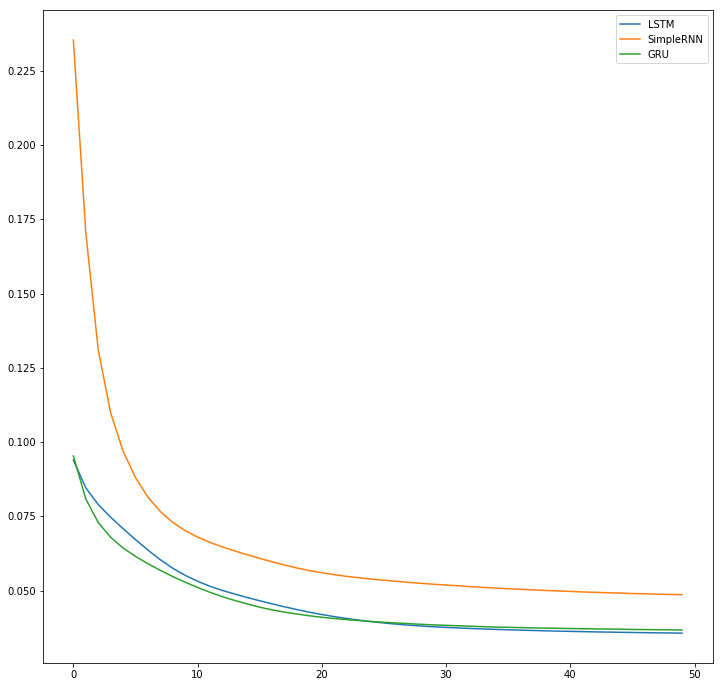

In [16]:
print(history.history.keys())
key_ = list(history.history.keys())[3]
plt.figure(figsize=(12, 12))
plt.plot(history.history[key_], label="LSTM")
plt.plot(history2.history[key_], label="SimpleRNN")
plt.plot(history3.history[key_], label="GRU")
plt.legend()
plt.show()

We can see that GRU and LSTM perform better than a Simple RNN. LSTM is also performing slightly better that GRU but require more computation time. We can also check the output and compare it to the real output provided by the graph (see the y description in preparation of data section)

In [17]:
print("Input :")
print(X_val)
print("\n\nLSTM predicts :")
y_pred = model.predict(X_val)
print(y_pred)
print("\n\nGRU predicts :")
y_pred = model3.predict(X_val)
print(y_pred)

Input :
[[[1 0 0 0 0 0 0]
  [0 0 0 0 1 0 0]
  [0 1 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


LSTM predicts :
[[[ 0.02   0.556  0.009 -0.018  0.444 -0.007 -0.007]
  [ 0.048  0.702  0.006  0.099 -0.013  0.113  0.   ]
  [ 0.007  0.711  0.033  0.073  0.003  0.228 -0.   ]
  [-0.001  0.694  0.007  0.07   0.021  0.274 -0.   ]
  [ 0.005  0.038  0.001  0.     0.726  0.079  0.022]
  [-0.04   0.034  0.202  0.821 -0.016  0.042  0.032]
  [-0.     0.625 -0.009  0.006 -0.003  0.423  0.014]
  [-0.003 -0.012 -0.002 -0.     0.702  0.284  0.077]
  [-0.053 -0.002  0.254  0.653 -0.028  0.063  0.027]
  [ 0.029  0.026  0.043  0.009  0.002  0.026  0.894]
  [ 0.011  0.007 -0.001 -0.008  0.     0.011 -0.003]
  [ 0.007 -0.001  0.001 -0.00

We can simply the output by removing small output and compare it to the possible output (we will only keep prediction from GRU)

In [18]:
y_pred = np.where(y_pred < 0.1, 0, y_pred)

In [19]:
for pred, real in zip(y_pred[0], y_possible[0]):
    print(pred, "\t", real)

[ 0.     0.586  0.     0.     0.414  0.     0.   ] 	 [0 1 0 0 1 0 0]
[ 0.     0.672  0.138  0.127  0.     0.277  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.623  0.     0.     0.     0.31   0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.602  0.1    0.     0.     0.338  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.779  0.232  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.164  0.782  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.571  0.     0.     0.     0.375  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.725  0.291  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.153  0.704  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.103  0.     0.     0.     0.     0.869] 	 [0 0 0 0 0 0 1]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.] 	 [0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  

Yeah !! Output is balanced between both offset but with different "probabilities". We can also check how well they are to generate sentences

## Use it as generator

As explained previously, we trained our model as a many-to-many RNN. Now we want a generator so we are going to use a one-to-many model but reusing knowledge from the training. 

Before that, we will need an evaluation function which take the output, pick the next input based on the probability to have this output, create the next input and run it until the graph is over. After that, we will check is the created word is really a Reber word. This will be done with following functions 

In [20]:
def Pick_From_Output(x):
    y = np.zeros_like(x)
    x = np.where(x < 0.1, 0, x)
    x = x[0]/x[0].sum(axis=1)
    i = np.random.choice(list(range(7)), size=1, p=x[0])
    y[0,0,i] = 1
    return y

def evaluate(model, nb_word = 1, max_iter = 50):
    good_pred = 0
    for _ in range(nb_word):
        model.reset_states()
        first_input = np.array([[[1,0,0,0,0,0,0]]])
        word = "B"
        loop = 0
        nextLetter = "B"
        next_seq = first_input
        while nextLetter != "E" and loop < max_iter:
            y_pred = model.predict(next_seq)
            next_seq = Pick_From_Output(y_pred)
            nextLetter = reber.sequenceToWord(next_seq[0])
            loop += 1
            word += nextLetter
        if reber.in_grammar(word):
            good_pred += 1
    acc = 100*good_pred/nb_word
    print("Good prediction : {:.2f}%".format(acc))
    return acc

In [29]:
nb_samples = 20

Now let's create both model as one-to-many and evaluate them 20 times on 100 words generated.

In [30]:
newModel = Sequential()
newModel.add(LSTM(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.set_weights(model.get_weights())

In [31]:
result_LSTM = []
for _ in range(nb_samples):
    result_LSTM.append(evaluate(newModel, 100, 50))

Good prediction : 86.00%
Good prediction : 84.00%
Good prediction : 85.00%
Good prediction : 84.00%
Good prediction : 88.00%
Good prediction : 82.00%
Good prediction : 82.00%
Good prediction : 86.00%
Good prediction : 84.00%
Good prediction : 86.00%
Good prediction : 89.00%
Good prediction : 89.00%
Good prediction : 90.00%
Good prediction : 89.00%
Good prediction : 91.00%
Good prediction : 90.00%
Good prediction : 91.00%
Good prediction : 89.00%
Good prediction : 81.00%
Good prediction : 87.00%


In [32]:
newModel = Sequential()

newModel.add(SimpleRNN(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.set_weights(model2.get_weights())

In [33]:
result_SRNN = []
for _ in range(nb_samples):
    result_SRNN.append(evaluate(newModel, 100, 50))

Good prediction : 6.00%
Good prediction : 3.00%
Good prediction : 6.00%
Good prediction : 12.00%
Good prediction : 8.00%
Good prediction : 6.00%
Good prediction : 4.00%
Good prediction : 7.00%
Good prediction : 7.00%
Good prediction : 7.00%
Good prediction : 6.00%
Good prediction : 5.00%
Good prediction : 11.00%
Good prediction : 4.00%
Good prediction : 11.00%
Good prediction : 7.00%
Good prediction : 4.00%
Good prediction : 9.00%
Good prediction : 5.00%
Good prediction : 7.00%


In [34]:
newModel = Sequential()
newModel.add(GRU(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.set_weights(model3.get_weights())

In [35]:
result_GRU = []
for _ in range(nb_samples):
    result_GRU.append(evaluate(newModel, 100, 50))

Good prediction : 76.00%
Good prediction : 81.00%
Good prediction : 85.00%
Good prediction : 70.00%
Good prediction : 83.00%
Good prediction : 74.00%
Good prediction : 76.00%
Good prediction : 78.00%
Good prediction : 78.00%
Good prediction : 76.00%
Good prediction : 79.00%
Good prediction : 84.00%
Good prediction : 76.00%
Good prediction : 66.00%
Good prediction : 73.00%
Good prediction : 76.00%
Good prediction : 84.00%
Good prediction : 78.00%
Good prediction : 72.00%
Good prediction : 81.00%


So we can see that bost LSTM and GRU outperform the standard RNN. In average LSTM is slightly better than GRU but takes also more time to train.

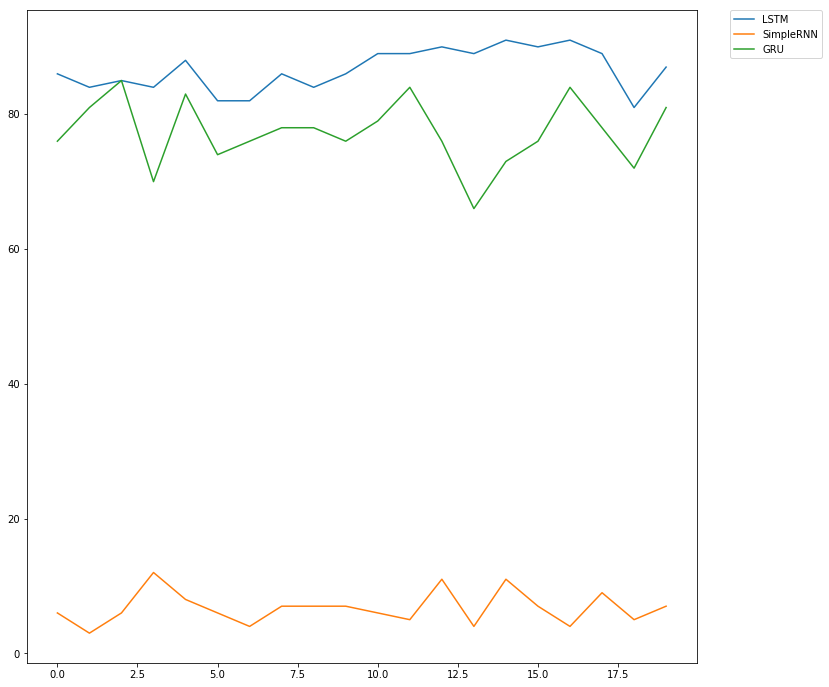

In [36]:
x = list(range(nb_samples))
y = [result_LSTM, result_SRNN, result_GRU]
labels = ["LSTM", "SimpleRNN", "GRU"]

plt.figure(figsize=(12, 12))
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Conclusion

In this workbook, we started to go through RNN. We check a simple model of both LSTM, GRU and SimpleRNN to check how fast and well they learn. On this example GRU and LSTM outperform the standard RNN due to the memory function. There is also a difference between LSTM and GRU but with slightly more epochs, they both perform similar. We can probably have better result by using a more advanced model but for such a simple model, we can see that it works really well.

## Going further

On a future notebook, we will explore Embedded Reber but using deeper RNNs